In [1]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset


import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import numpy as np # linear algebra
import pandas as pd # data processing

In [2]:
print(torch.__version__)

1.1.0


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'GeForce GTX 1060 3GB'

In [4]:
#try give data to device (GPU)
'''
data = torch.eye(3)
data = data.to(device)
print(data.get_device())
'''

'\ndata = torch.eye(3)\ndata = data.to(device)\nprint(data.get_device())\n'

In [5]:
class GridDataset(Dataset):
    """Grids dataset."""
    
    def __init__(self, csv_file, csv_file_labels, transform=None):
        '''
        Args:
            csv_file (string): Path to the .csv file which contains pd.DataFrames in 1D.
            csv_file_labels (string): Path to the .csv file which contains labels of grids.
            transform (callable, optional): Optional transform to be applied on a sample.
            
        '''
        
        self.data_set = pd.read_csv(csv_file)
        self.label = pd.read_csv(csv_file_labels)
        self.transform = transform
        
    
    def __len__(self):
        return len(self.data_set.columns) #returns the size of the dataset (nomber of columnss)
    
    def __getitem__(self, idx):
        grid = self.data_set.iloc[:, idx].values
        grid = grid.reshape(1, -1)
        grid_name = self.data_set.columns[idx]
        label = self.label.iloc[:, idx].values
        
        
        if self.transform:
            grid = self.transform(grid)
            label = torch.from_numpy(label)
            #noise = np.random.normal(loc=0, scale=0.1)
            if label == 0:
                #grid = grid.new_full((24, 18, 15), 0+noise)
                grid = grid * 10
            else:
                #grid = grid.new_full((24, 18, 15), 1+noise)
                grid = grid / 10
            grid = grid.to(device)
            label = label.to(device)
        sample = {'grid': grid, 'grid_name': grid_name, 'label': label}
        
        ##return grid, grid_name, label
        return sample 
    
    def stats(self):
        '''mean and std of entire dataset'''
        mean = self.data_set.values.mean()
        std = self.data_set.values.std()
        stats = {'mean': mean, 'std':std}
        return stats

In [6]:
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
import pandas as pd
import numpy as np
        
class RescaleTo3D(object):
    """Rescale the grid to a given size.

    Args:
        i_max - dimension in X
        j_max - dimension in Y
        k_max - dimension in Z

    Return:
        ThreeDim - 3d np.array  
        
    """    
    
    def __init__(self, i_max, j_max, k_max):
        self.i_max = i_max
        self.j_max = j_max
        self.k_max = k_max
        
    def __call__(self, sample):
    
        #приводим массив к 3D размерности грида.    
        Three_Dim = np.array(np.zeros((self.i_max, self.j_max, self.k_max)))        
        i = 0
        j = 0
        k = 0
        z = 0
        while k <= self.k_max-1:
            while j <= self.j_max-1:
                while i <= self.i_max-1:
                    Three_Dim[i, j ,k] = sample[:,z]
                    i += 1
                    z += 1
                i = 0
                j += 1
            j = 0
            k += 1

        return (Three_Dim)     

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return (torch.from_numpy(sample))

class Normalize(object):
    '''Normalize tensor to [-1,1]. made it by myself, cause unable to use transforms.Normalize. Do not why'''
    def __call__(self, sample):
        sample =  sample.sub_(train_dataset.stats()['mean']).div_(train_dataset.stats()['std'])
        return(sample)

In [7]:
#let's create dataset for grids
path  = "../DATA/_PERMX.csv" #path to dataset
path_labels  = "../DATA/_PERMX_labels.csv" #path to dataset

train_dataset = GridDataset(path,
                            path_labels,
                            transform=transforms.Compose([RescaleTo3D(24, 18, 15),
                                                        ToTensor(),
                                                         Normalize()]))

#validation_dataset = GridDataset(path,
#                            path_labels,
#                            transform=transforms.Compose([RescaleTo3D(24, 18, 15),
#                                                        ToTensor()]))


In [8]:
print(train_dataset.__len__())

2000


In [9]:
#Build a Convolutional Network class with two Convolutional layers and one fully connected layer

class Grids_Conv3d(nn.Module):
    def __init__(self, out_1=32, out_2=64):
        super(Grids_Conv3d, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=out_1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv3d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(4608, 1000)
        self.fc2 = nn.Linear(1000, 2) #number of classes
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [10]:
# Create the model object using CNN class

model = Grids_Conv3d(out_1=32, out_2=64)
model = model.to(device)
print("Print the model:\n ", model)

Print the model:
  Grids_Conv3d(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (fc1): Linear(in_features=4608, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)


In [11]:
#Define the loss function, the optimizer and the dataset loader

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
#validation_loader = DataLoader(dataset=validation_dataset, batch_size=50, shuffle=False)

In [12]:
#Train the model and determine validation accuracy technically test accuracy

n_epochs = 50
loss_list = []
accuracy_list = []
total_step = len(train_loader)
model.train()

def train(epochs):
    for epoch in range(epochs):
        for batch_idx, sample in enumerate(train_loader):
            optimizer.zero_grad()
            grid = sample['grid'].unsqueeze(1).float()
            z = model(grid)
            label = sample['label'].view(-1)
            loss = criterion(z, label)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
            
            total = label.size(0)
            _, yhat = torch.max(z.data, 1)
            correct = (yhat == label).sum().item()
            accuracy_list.append(correct / total)
            

        
        if (batch_idx+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, epochs, batch_idx + 1, total_step, loss.item(),
                          (correct / total) * 100))
            
            
train(n_epochs)

Epoch [1/50], Step [20/20], Loss: 0.5072, Accuracy: 54.00%
Epoch [2/50], Step [20/20], Loss: 0.1886, Accuracy: 95.00%
Epoch [3/50], Step [20/20], Loss: 0.7757, Accuracy: 48.00%
Epoch [4/50], Step [20/20], Loss: 0.6976, Accuracy: 51.00%
Epoch [5/50], Step [20/20], Loss: 0.6881, Accuracy: 56.00%
Epoch [6/50], Step [20/20], Loss: 0.6925, Accuracy: 52.00%
Epoch [7/50], Step [20/20], Loss: 0.7007, Accuracy: 45.00%
Epoch [8/50], Step [20/20], Loss: 0.6947, Accuracy: 47.00%
Epoch [9/50], Step [20/20], Loss: 0.7186, Accuracy: 48.00%
Epoch [10/50], Step [20/20], Loss: 0.6964, Accuracy: 48.00%
Epoch [11/50], Step [20/20], Loss: 0.6861, Accuracy: 56.00%
Epoch [12/50], Step [20/20], Loss: 0.7201, Accuracy: 48.00%
Epoch [13/50], Step [20/20], Loss: 0.7103, Accuracy: 49.00%
Epoch [14/50], Step [20/20], Loss: 0.7400, Accuracy: 41.00%
Epoch [15/50], Step [20/20], Loss: 0.6972, Accuracy: 51.00%
Epoch [16/50], Step [20/20], Loss: 0.7058, Accuracy: 47.00%
Epoch [17/50], Step [20/20], Loss: 0.6927, Accura

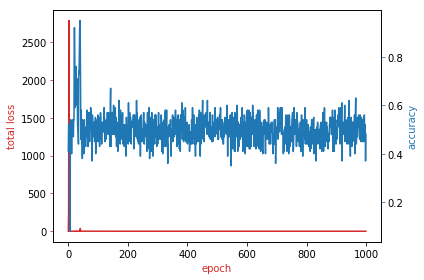

In [13]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [14]:
#clear cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print ('cleared')
    
#torch.cuda.memory_cached() # check memore cached

cleared


In [15]:
validation_dataset = GridDataset(path,
                            path_labels,
                            transform=transforms.Compose([RescaleTo3D(24, 18, 15),
                                                        ToTensor(),
                                                        Normalize()]))

In [ ]:
validation_loader = DataLoader(dataset=validation_dataset, batch_size=50, shuffle=True)

model.eval()
with torch.no_grad():
    val_correct = 0
    val_total = 0
    for batch_idx, val_sample in enumerate(validation_loader):
        val_grid = val_sample['grid'].unsqueeze(1).float()
        val_z = model(val_grid)
        val_label = val_sample['label'].view(-1)
            
        val_total += val_label.size(0)
        _, val_yhat = torch.max(val_z.data, 1)
        val_correct += (val_yhat == val_label).sum().item()
        #print('prediction', val_yhat)
        #print('truth', val_label)
    print('Test Accuracy of the model on the 2000 test grids: {} %'.format((val_correct / val_total) * 100))